<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [0]:
!pip install --pre --quiet astroquery

In [111]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0


## Datos del SDSS

Disponible en enlace



###Consulta con Astroquery###

In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 100000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z, s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'STAR'
                      
                      """)

In [150]:
datapd=data.to_pandas()
datapd = datapd[(datapd != -9999).dropna()]
datapd = datapd.dropna()
print(datapd)

       fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0        20.48503    18.48349    17.61969    17.21026    16.96410        4457
1        18.33818    16.83223    16.19494    15.89421    15.72003        6155
2        22.81749    21.94995    21.65532    21.49359    21.26813        5063
3        21.87878    20.64922    20.36301    20.14630    19.93022        3705
4        18.94203    18.00459    17.70750    17.59729    17.55546        3705
5        18.20357    17.16672    17.05190    17.03187    17.02803        7500
6        18.49530    17.25698    16.72305    16.51210    16.37836        5320
7        16.81897    15.65400    15.16061    14.93756    14.83189        6000
8        21.31538    18.69088    17.46540    16.98676    16.69788        4246
9        20.26561    18.99056    18.46834    18.24545    18.12724        5873
10       18.50102    16.36112    15.55532    15.26001    15.08880        5211
11       25.68861    23.84693    22.21437    19.36426    17.6419

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)

### Chequeo a los datos

Estadísticas:

In [152]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,79989.0,20.982482,2.117595,14.01740,19.41306,20.80950,22.61272,29.04885
fiberMag_g,79989.0,19.600113,1.998392,13.48535,18.12156,19.45434,21.28307,29.52714
fiberMag_r,79989.0,19.002542,1.891515,12.84478,17.54710,18.96646,20.64430,24.66934
fiberMag_i,79989.0,18.684114,1.822551,12.73436,17.28252,18.68764,20.17181,27.58280
fiberMag_z,79989.0,18.497855,1.802802,12.13546,17.12093,18.46012,19.92276,24.00791


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [0]:
norm_train_labels = norm(train_labels)
norm_train_feat = norm(train_feat)

norm_test_feat = norm(test_feat)

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

###Estructura de la red neuronal

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    layers.Dense(5, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

###Desnormalización

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo

### Inspección del modelo

In [158]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [159]:
# Imprime un punto por cada epoch completado
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

El progreso de entrenamiento del sistema está en el objeto `history`.

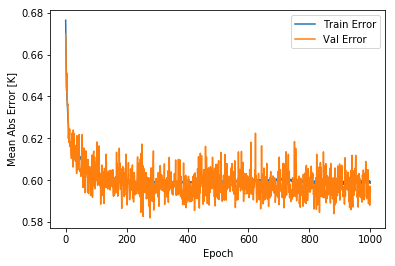

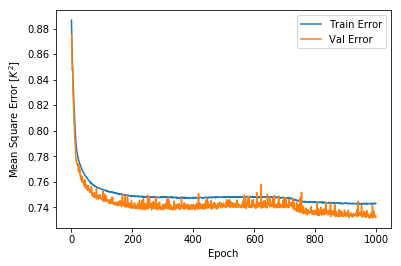

In [160]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

###Tiempo de Ejecución

In [0]:
t_fin = time()
t_ejecucion = t_fin - t_ini

### Predicción con los datos de prueba

(3195.3926533011486, 14076.607346698851, 3195.4, 14076.614693397702)

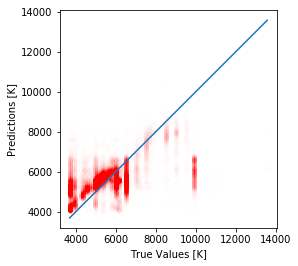

In [183]:
test_predictions = model.predict(norm_test_feat).flatten()

test_predictions = desnorm(test_predictions, train_labels.mean(), train_labels.std())
m1 = min(test_labels)
M1 = max(test_labels)

m2 = min(test_predictions)
M2 = max(test_predictions)

m = min([m1, m2])
M = max([M1, M2])

plt.scatter(test_labels, test_predictions,s=20, alpha = 0.002,color='red')
plt.plot([m , M], [m, M])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

Notemos que nuestro modelo se debe acercar a la función de  identidad. Ahora veamos la distribución del error absoluto:



### Errores

Tiempo de Ejecución: 2875.8711030483246
Error Absoluto Medio: 906.8250122070312
Error Cuadrático Medio: 1682028.375


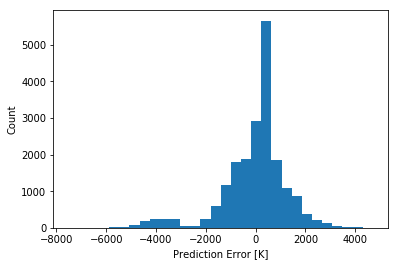

In [163]:
import numpy as np
error = test_predictions - test_labels
error2 = error**2

plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

MeanAbsError = np.abs(error).mean()
MeanSQError = error2.mean()

print('Tiempo de Ejecución:', t_ejecucion)
print('Error Absoluto Medio:', MeanAbsError)
print('Error Cuadrático Medio:', MeanSQError)